Import and Set up

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import copy
import matplotlib.pyplot as plt
import os # For Colab path handling

# Check for GPU availability and set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


Connect to Google Dirve

In [ ]:
# Cell 1.5: Mount Google Drive and Ensure Directories
from google.colab import drive
# import os # Ensure os is imported

drive.mount('/content/drive')

# --- Define BASE paths for directories in your Google Drive ---
DRIVE_PROJECT_BASE = '/content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation'
MODELS_DIR_PATH = os.path.join(DRIVE_PROJECT_BASE, 'models')
RESULTS_DIR_PATH = os.path.join(DRIVE_PROJECT_BASE, 'results')

# --- Ensure the target directories exist in Drive ---
for path_to_check in [MODELS_DIR_PATH, RESULTS_DIR_PATH]:
    try:
        os.makedirs(path_to_check, exist_ok=True)
        print(f"Directory ensured at: {path_to_check}")
    except OSError as e:
        print(f"Error creating directory {path_to_check}: {e}")
        # Provide more context if needed
    except Exception as e:
         print(f"An unexpected error occurred while checking/creating {path_to_check}: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory ensured at: /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/models
Directory ensured at: /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/results


Hyperparameters and Configuration

In [ ]:
# Configuration based on typical ResNet training on CIFAR-10
BATCH_SIZE = 128
LEARNING_RATE = 0.1 # Initial learning rate for SGD
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4 # L2 regularization
EPOCHS = 100 # Adjust as needed, ResNet-50 might benefit from more epochs (e.g., 160-200) for best results
NUM_CLASSES = 10 # CIFAR-10 has 10 classes

# Learning Rate Scheduler Milestones
LR_MILESTONES = [int(EPOCHS * 0.5), int(EPOCHS * 0.75)] # Adjust if EPOCHS change significantly
LR_GAMMA = 0.1 # Factor to reduce LR by

# --- Define Model and Plot Filenames ---
MODEL_FILENAME = 'resnet50_baseline_cifar10.pth'      # <<< Updated filename
PLOT_FILENAME = 'resnet50_baseline_training_curves.png' # <<< Updated filename

# --- Construct full paths using variables from Cell 1.5 ---
MODEL_SAVE_PATH = os.path.join(MODELS_DIR_PATH, MODEL_FILENAME)
PLOT_SAVE_PATH = os.path.join(RESULTS_DIR_PATH, PLOT_FILENAME)

print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Initial Learning Rate: {LEARNING_RATE}")
print(f"LR Milestones: {LR_MILESTONES}")
print(f"Model will be saved to: {MODEL_SAVE_PATH}")
print(f"Plot will be saved to: {PLOT_SAVE_PATH}")

Epochs: 100
Batch Size: 128
Initial Learning Rate: 0.1
LR Milestones: [50, 75]
Model will be saved to: /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/models/resnet50_baseline_cifar10.pth
Plot will be saved to: /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/results/resnet50_baseline_training_curves.png


Data Loading and Transforming

In [ ]:
print("Setting up CIFAR-10 data transformations...")
# Normalization values for CIFAR-10
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

print("Loading CIFAR-10 dataset...")
# Use /content/data for Colab storage
trainset = torchvision.datasets.CIFAR10(
    root='/content/data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='/content/data', train=False, download=True, transform=transform_test)
testloader = DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print("Dataset loaded.")
print(f"Training set size: {len(trainset)}")
print(f"Test set size: {len(testset)}")

Setting up CIFAR-10 data transformations...
Loading CIFAR-10 dataset...
Dataset loaded.
Training set size: 50000
Test set size: 10000


Model Definition (ResNet-50 Baseline)

In [ ]:
print("Defining ResNet-50 model using torchvision...")

# Load ResNet-50 architecture.
# Set weights=None for random initialization (true baseline from scratch).
# Using weights='IMAGENET1K_V1' might speed up convergence but uses pre-training.
# For baseline comparison, None is often preferred unless specified otherwise.
model = torchvision.models.resnet50(weights=None)

# Modify the final fully connected layer for CIFAR-10 (10 classes)
num_ftrs = model.fc.in_features  # Get the number of features input to the original fc layer
model.fc = nn.Linear(num_ftrs, NUM_CLASSES) # Replace with a new layer matching NUM_CLASSES

print("ResNet-50 architecture loaded and final layer adapted for CIFAR-10.")

# Optional: Print model structure
# print(model)

Defining ResNet-50 model using torchvision...
ResNet-50 architecture loaded and final layer adapted for CIFAR-10.


Instantiate Model, Loss, Optimizer, Scheduler

In [ ]:
print("Instantiating ResNet-50 model...")
# Ensure the model instantiation here matches Cell 4
# model = torchvision.models.resnet50(weights=None) # Re-instantiate or use the 'model' from Cell 4
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, NUM_CLASSES) # Ensure modification is applied

model = model.to(DEVICE) # Move model defined in Cell 4 to the device
print("Model instantiated and moved to device.")

# Loss Function
criterion = nn.CrossEntropyLoss()
print("Loss function: CrossEntropyLoss")

# Optimizer (SGD is standard for ResNets on CIFAR)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE,
                      momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
print(f"Optimizer: SGD (LR={LEARNING_RATE}, Momentum={MOMENTUM}, WD={WEIGHT_DECAY})")

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=LR_MILESTONES, gamma=LR_GAMMA)
print(f"LR Scheduler: MultiStepLR (milestones={LR_MILESTONES}, gamma={LR_GAMMA})")

Instantiating ResNet-50 model...
Model instantiated and moved to device.
Loss function: CrossEntropyLoss
Optimizer: SGD (LR=0.1, Momentum=0.9, WD=0.0005)
LR Scheduler: MultiStepLR (milestones=[50, 75], gamma=0.1)


Training and Validation Functions

In [ ]:
def train_one_epoch(epoch, model, trainloader, optimizer, criterion, device):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    print_freq = len(trainloader) // 4 # Print progress roughly 4 times per epoch

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print progress
        if (i + 1) % print_freq == 0 or (i + 1) == len(trainloader):
             print(f'Epoch [{epoch + 1}/{EPOCHS}], Step [{i + 1}/{len(trainloader)}], '
                   f'Loss: {running_loss / (i + 1):.4f}')

    epoch_time = time.time() - start_time
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    print(f'---> Epoch {epoch + 1} Training Summary: Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Time: {epoch_time:.2f}s')
    return epoch_loss, epoch_acc

def validate(model, testloader, criterion, device):
    model.eval() # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    with torch.no_grad(): # No need to track gradients during validation
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_time = time.time() - start_time
    val_loss = running_loss / len(testloader)
    val_acc = 100. * correct / total
    print(f'---> Validation Summary: Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, Time: {epoch_time:.2f}s')
    return val_loss, val_acc

print("Training and validation functions defined.")

Training and validation functions defined.


Main Training Loop

In [ ]:
print(f"Starting Baseline Training for {EPOCHS} epochs...")
start_train_time = time.time()

best_val_acc = 0.0
# No need to initialize best_model_wts here, just save directly

# History tracking for plots
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr:.6f}")
    history['lr'].append(current_lr)

    # Train for one epoch
    train_loss, train_acc = train_one_epoch(epoch, model, trainloader, optimizer, criterion, DEVICE)

    # Validate the model
    val_loss, val_acc = validate(model, testloader, criterion, DEVICE)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Update learning rate using the scheduler
    scheduler.step()

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        print(f"Validation accuracy improved ({best_val_acc:.2f}% -> {val_acc:.2f}%). Saving model...")
        best_val_acc = val_acc
        # Save the model state dict directly to the path defined in Cell 2
        try:
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Model saved to {MODEL_SAVE_PATH}")
        except Exception as e:
            print(f"Error saving model to {MODEL_SAVE_PATH}: {e}")


total_train_time = time.time() - start_train_time
print("\nFinished Baseline Training.")
print(f"Total Training Time: {total_train_time // 60:.0f}m {total_train_time % 60:.0f}s")
print(f"Best Validation Accuracy achieved: {best_val_acc:.2f}%")
print(f"Best model saved at: {MODEL_SAVE_PATH}")

Starting Baseline Training for 100 epochs...

--- Epoch 1/100 ---
Current Learning Rate: 0.100000
Epoch [1/100], Step [97/391], Loss: 10.5199
Epoch [1/100], Step [194/391], Loss: 6.5430
Epoch [1/100], Step [291/391], Loss: 5.1423
Epoch [1/100], Step [388/391], Loss: 4.4042
Epoch [1/100], Step [391/391], Loss: 4.3866
---> Epoch 1 Training Summary: Loss: 4.3866, Acc: 13.36%, Time: 32.93s
---> Validation Summary: Loss: 2.0540, Acc: 19.22%, Time: 2.76s
Validation accuracy improved (0.00% -> 19.22%). Saving model...
Model saved to /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/models/resnet50_baseline_cifar10.pth

--- Epoch 2/100 ---
Current Learning Rate: 0.100000
Epoch [2/100], Step [97/391], Loss: 2.0807
Epoch [2/100], Step [194/391], Loss: 2.0519
Epoch [2/100], Step [291/391], Loss: 2.0263
Epoch [2/100], Step [388/391], Loss: 1.9986
Epoch [2/100], Step [391/391], Loss: 1.9980
---> Epoch 2 Training Summary: Loss: 1.9980, Acc: 23.53%, Time: 2

Plotting Results


Plotting training history...
Plot saved to /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/results/resnet50_baseline_training_curves.png


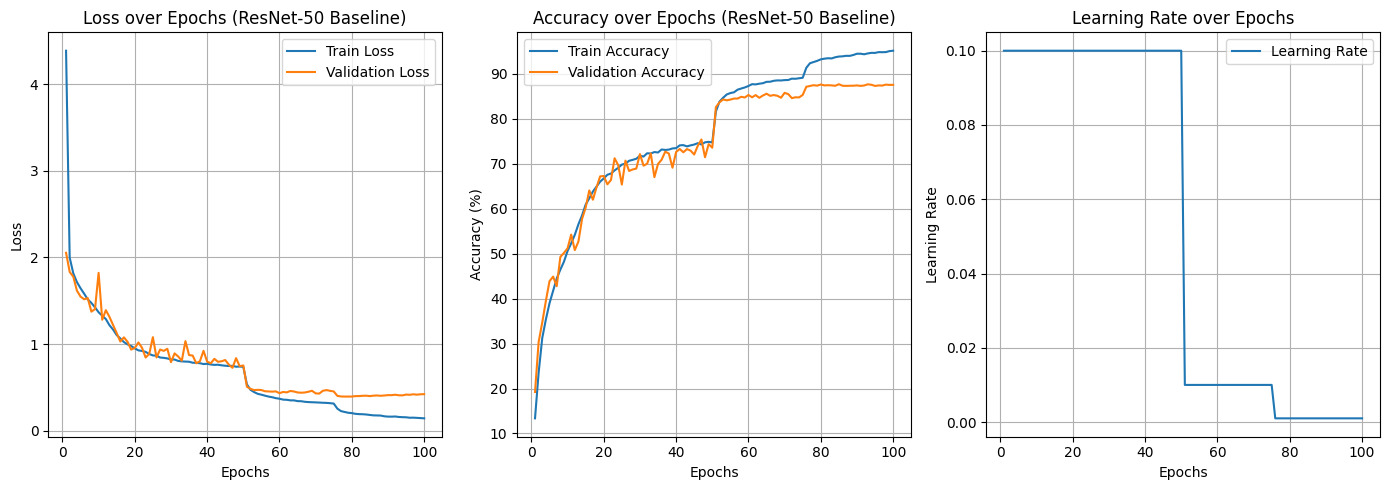

In [ ]:
print("\nPlotting training history...")

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs (ResNet-50 Baseline)') # Added model name
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over Epochs (ResNet-50 Baseline)') # Added model name
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot Learning Rate
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['lr'], label='Learning Rate')
plt.title('Learning Rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
# Save the plot using the path defined in Cell 2
try:
    plt.savefig(PLOT_SAVE_PATH)
    print(f"Plot saved to {PLOT_SAVE_PATH}")
except Exception as e:
    print(f"Error saving plot to {PLOT_SAVE_PATH}: {e}")

plt.show()

Final Test with Best Model

In [ ]:
print("\nEvaluating the best model on the test set...")

# --- Instantiate the ResNet-50 architecture again ---
# Make sure this matches the definition used for training (Cell 4/5)
best_model = torchvision.models.resnet50(weights=None) # Use same weights setting as training
num_ftrs = best_model.fc.in_features
best_model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
# --- End of instantiation ---

try:
    # Load the best model weights saved during training (using path from Cell 2)
    best_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    best_model.to(DEVICE)
    print("Best model weights loaded successfully.")

    # Perform final validation using the loaded best model
    final_loss, final_acc = validate(best_model, testloader, criterion, DEVICE)
    print(f"\nFinal Test Accuracy of the best ResNet-50 baseline model: {final_acc:.2f}%")

except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_SAVE_PATH}. Ensure training completed and saved the file.")
except Exception as e:
    print(f"An error occurred while loading or evaluating the model: {e}")


Evaluating the best model on the test set...
Best model weights loaded successfully.
---> Validation Summary: Loss: 0.3994, Acc: 87.68%, Time: 3.76s

Final Test Accuracy of the best ResNet-50 baseline model: 87.68%
